In [ ]:
import cv2
import numpy as np

DEFAULT_HEIGHT = 4032

def parse(image_path: str) -> None:
    """
    Parse the crossword image to find lines and intersections.
    """
    # Read and resize the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (int(image.shape[1] * DEFAULT_HEIGHT / image.shape[0]), DEFAULT_HEIGHT))

    clean_image  = image.copy()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(gray, (5, 5), 0)  # Apply Gaussian blur to reduce noise

    edges = cv2.Canny(img_blur,100,200,apertureSize = 3)
    cv2.imwrite('canny1.jpg',edges)
    kernel = np.ones((15,15),np.uint8)
    edges = cv2.dilate(edges,kernel,iterations = 1)
    cv2.imwrite('canny2.jpg',edges)
    kernel = np.ones((2,2),np.uint8)
    edges = cv2.erode(edges,kernel,iterations = 1)
    cv2.imwrite('canny3.jpg',edges)

    thresh = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)

    white_image = edges.copy()
    white_image[:] = 0

    lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=500, maxLineGap=25)

    # Draw the lines on the original image
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.line(white_image, (x1, y1), (x2, y2), 255, 2)

    kernel = np.ones((15,15),np.uint8)
    white_image = cv2.dilate(white_image,kernel,iterations = 1)
    white_image = 255 - white_image
    cnts, hierarchy = cv2.findContours(white_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rectangles = [cv2.boundingRect(c) for c in cnts]
    centers = [(x + w // 2, y + h // 2) for (x, y, w, h) in rectangles]
    ratios = [min(w, h) / max(w, h) for (x, y, w, h) in rectangles]
    import pandas as pd

    contours_infos = pd.DataFrame(
        {
            "center": centers,
            "ratio": ratios,
            "area": [cv2.contourArea(c) for c in cnts],
            "rectangle": rectangles,
            "parent": hierarchy[0][:, -1],
        }
    )
    contours_infos["diff_99_num_siblings"] = (contours_infos["parent"].map(contours_infos["parent"].value_counts())-99).abs()
    contours_infos["is_closest_to_99_siblings"] = contours_infos["diff_99_num_siblings"] == contours_infos["diff_99_num_siblings"].min()
    contours_infos["center_x"] = contours_infos["center"].apply(lambda x: x[0])
    contours_infos["center_y"] = contours_infos["center"].apply(lambda x: x[1])
    # TODO: automate this
    contours_infos = contours_infos[contours_infos["is_closest_to_99_siblings"]]
    contours_infos["center_x_bin"] = pd.cut(contours_infos["center_x"], bins=9)
    contours_infos["center_y_bin"] = pd.cut(contours_infos["center_y"], bins=11)
    def fit_line(x,y):
        # Fit line using least squares
        A = np.vstack([x, np.ones(len(x))]).T
        m, b = np.linalg.lstsq(A, y, rcond=None)[0]

        print(f"Estimated line: y = {m:.3f}x + {b:.3f}")
        return (m,b)
    x_lines = []
    y_lines = []
    for _,df in contours_infos.groupby("center_x_bin"):
        x_lines.append(
            fit_line(df.center_x.to_numpy(), df.center_y.to_numpy())
        )
    for _,df in contours_infos.groupby("center_y_bin"):
        y_lines.append(
            fit_line(df.center_x.to_numpy(), df.center_y.to_numpy())
        )
    cv2.imwrite('thresh.jpg', thresh)
    cv2.imwrite('lines.jpg', image)
    cv2.imwrite('contours.jpg', white_image)
    from itertools import chain

    for line in chain(x_lines, y_lines):
        m, b = line
        x = np.linspace(0, white_image.shape[1], 100)
        y = m * x + b
        for i in range(len(x) - 1):
            cv2.line(white_image, (int(x[i]), int(y[i])), (int(x[i+1]), int(y[i+1])), (0, 255, 0), 2)
    cv2.imwrite('contours.jpg', white_image)
    from itertools import product

    intersections = []

    for lines in product(x_lines, y_lines):
        m1, b1 = lines[0]
        m2, b2 = lines[1]
        x = (b2 - b1) / (m1 - m2)
        y = m1 * x + b1
        intersections.append((x, y))
    brightness_values = []
    radius = 50
    clean_gray = cv2.cvtColor(clean_image, cv2.COLOR_BGR2GRAY)

    for x, y in intersections:
        # Create a circular mask of the same size as the image
        mask = np.zeros_like(clean_gray, dtype=np.uint8)
        cv2.circle(mask, (int(x), int(y)), radius, 255, -1)

        # Compute the mean brightness within the masked region
        mean_val = cv2.mean(clean_gray, mask=mask)[0]  # [0] gets the mean intensity (single channel)
        brightness_values.append(mean_val)

        cv2.circle(clean_image, (int(x), int(y)), 50, (int(mean_val), 0, 0), -1)
    df_inter = pd.DataFrame({
        "x": [x for x, _ in intersections],
        "y": [y for _, y in intersections],
        "brightness": brightness_values,
    }).sort_values(by="brightness", ascending=True).reset_index(drop=True)

    df_inter["delta"] = df_inter["brightness"].diff().fillna(0)
    delta_argmax = df_inter.delta.argmax()
    df_inter["is_white"] = df_inter.index >= delta_argmax
    df_inter["is_white"].value_counts()
    cv2.imwrite('points.jpg', clean_image)

    return list(zip(df_inter['x'].astype(int), df_inter['y'].astype(int)))

In [59]:
for inter in intersections:
    x, y = inter
    cv2.circle(image, (int(x), int(y)), 50, (255, 0, 0), -1)

In [ ]:
# Draw the line on the image (BGR color, thickness)
cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)


In [25]:
contours_infos

,center,ratio,area,rectangle,parent,diff_99_num_siblings,is_closest_to_99_siblings,center_x,center_y,center_x_bin,center_y_bin
34,"(407, 2583)",0.984733,16066.0,"(342, 2519, 131, 129)",33,0,True,407,2583,"(375.711, 520.222]","(2429.636, 2583.0]"
35,"(570, 2581)",0.962406,16297.5,"(504, 2517, 133, 128)",33,0,True,570,2581,"(520.222, 663.444]","(2429.636, 2583.0]"
36,"(729, 2579)",0.977273,16079.0,"(663, 2515, 132, 129)",33,0,True,729,2579,"(663.444, 806.667]","(2429.636, 2583.0]"
37,"(889, 2577)",0.969697,16079.5,"(823, 2513, 132, 128)",33,0,True,889,2577,"(806.667, 949.889]","(2429.636, 2583.0]"
38,"(1042, 2573)",0.952756,14800.5,"(982, 2510, 121, 127)",33,0,True,1042,2573,"(949.889, 1093.111]","(2429.636, 2583.0]"
...,...,...,...,...,...,...,...,...,...,...,...
128,"(1031, 911)",0.942857,17612.5,"(965, 841, 132, 140)",33,0,True,1031,911,"(949.889, 1093.111]","(894.313, 1049.364]"
129,"(870, 907)",0.949640,17314.0,"(804, 838, 132, 139)",33,0,True,870,907,"(806.667, 949.889]","(894.313, 1049.364]"
130,"(706, 904)",0.985714,18472.0,"(636, 835, 140, 138)",33,0,True,706,904,"(663.444, 806.667]","(894.313, 1049.364]"
131,"(543, 900)",0.986014,19197.0,"(472, 830, 143, 141)",33,0,True,543,900,"(520.222, 663.444]","(894.313, 1049.364]"


In [14]:
fit_line(1)

Estimated line: y = 1.035x + 0.925


In [105]:
hierarchy = hierarchy.squeeze()
hierarchy.shape

(133, 4)

In [ ]:
Structure of hierarchy:

It’s a NumPy array of shape (1, N, 4), where N is the number of contours.

Each contour has 4 elements: [Next, Previous, First_Child, Parent].

In [107]:
(hierarchy[:,-1] == 33).sum()

np.int64(99)

In [ ]:
# draw the contours with highest areas:
if cnts:
    # Sort contours by area and keep the largest ones
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        cv2.drawContours(image, [c], -1, (0, 255, 0), 2)

In [ ]:
# get bounding square of each contour
rectangles = [cv2.boundingRect(c) for c in cnts]
centers = [(x + w // 2, y + h // 2) for (x, y, w, h) in rectangles]
ratios = [min(w, h) / max(w, h) for (x, y, w, h) in rectangles]
# Draw rectangles around contours
for (x, y, w, h) in rectangles:
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)

In [ ]:
# compute min(a,b)/max(a,b) for each rectangle:


In [91]:
sum([r > 0.8 for r in ratios])  # Count how many rectangles are close to square

101

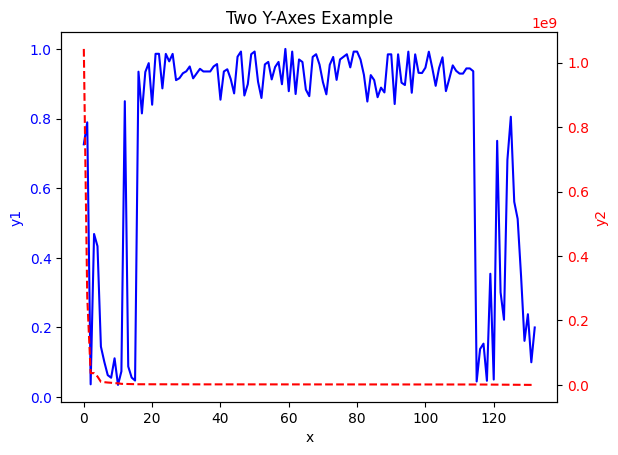

In [100]:
fig, ax1 = plt.subplots()

ax1.plot(ratios, 'b-', label='y1')
ax1.set_xlabel('x')
ax1.set_ylabel('y1', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot([100*a for a in areas], 'r--', label='y2')
ax2.set_ylabel('y2', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title("Two Y-Axes Example")
plt.show()

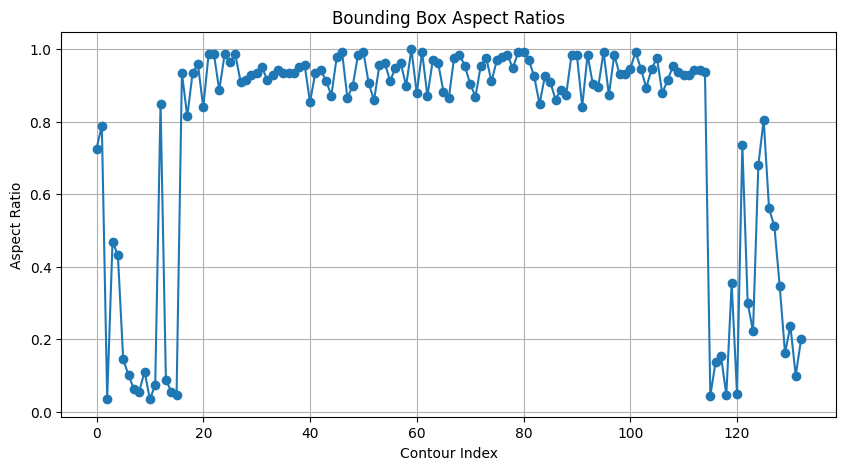

In [ ]:
# plot rectangle areas and rectangle aspect ratio:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(ratios, marker='o')
plt.title('Bounding Box Aspect Ratios')
plt.xlabel('Contour Index')
plt.ylabel('Aspect Ratio')
plt.grid()
plt.show()

In [84]:
cv2.imwrite('thresh.jpg', thresh)
cv2.imwrite('lines.jpg', image)
cv2.imwrite('contours.jpg', white_image)

True

In [24]:
from main import parse_crossword_image

In [25]:
with open("uploads/image.jpg", "rb") as f:
    image_bytes = f.read()

In [27]:
inputs = parse_crossword_image(image_bytes)
len(inputs)

5090